# Transfer Learning - Feature Extraction

In [1]:
# Importing TF and checking the version
import tensorflow as tf
print(tf.__version__)

2.10.0


In [2]:
# Inspecting our dataset
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

There are 2 directories and 0 images in 10_food_classes_10_percent.
There are 10 directories and 0 images in 10_food_classes_10_percent\test.
There are 0 directories and 250 images in 10_food_classes_10_percent\test\chicken_curry.
There are 0 directories and 250 images in 10_food_classes_10_percent\test\chicken_wings.
There are 0 directories and 250 images in 10_food_classes_10_percent\test\fried_rice.
There are 0 directories and 250 images in 10_food_classes_10_percent\test\grilled_salmon.
There are 0 directories and 250 images in 10_food_classes_10_percent\test\hamburger.
There are 0 directories and 250 images in 10_food_classes_10_percent\test\ice_cream.
There are 0 directories and 250 images in 10_food_classes_10_percent\test\pizza.
There are 0 directories and 250 images in 10_food_classes_10_percent\test\ramen.
There are 0 directories and 250 images in 10_food_classes_10_percent\test\steak.
There are 0 directories and 250 images in 10_food_classes_10_percent\test\sushi.
There are 

In [3]:
# Creating data loaders
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images")
train_data_10_percent = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

print("Testing images")
test_data_10_percent = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

Training images
Found 750 images belonging to 10 classes.
Testing images
Found 2500 images belonging to 10 classes.


In [4]:
# Creating and using callbacks
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to {log_dir}")
    return tensorboard_callback

## Re-using trained models from TensorFlow Hub

In [26]:
# Getting trained image classification ML models from tfhub.dev
url_resnet = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
url_efficientnet = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"

In [7]:
# Import dependencies
import tensorflow_hub as hub
from tensorflow.keras import layers

In [10]:
# Function to create a model from URL
def create_model(model_url, num_classes=10):
    
    # Download TFHub model and save as a Keras layer
    feature_extraction_layer = hub.KerasLayer(
        model_url,
        trainable=False,
        name="feature_extraction_layer",
        input_shape=IMAGE_SHAPE+(3,)
    )

    # Create our model
    model = tf.keras.Sequential([
        feature_extraction_layer,
        layers.Dense(num_classes, activation="softmax", name="output_layer")
    ])

    return model

In [11]:
# Creating Resnet model
model_resnet = create_model(url_resnet, num_classes=train_data_10_percent.num_classes)

In [12]:
# Checking the model
model_resnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [13]:
# Compiling the model
model_resnet.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [19]:
# Fit the model
history1 = model_resnet.fit(
    train_data_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data_10_percent,
    validation_steps=len(test_data_10_percent),
    callbacks=[create_tensorboard_callback("./", "resnet_1")]
)

Saving TensorBoard log files to .//resnet_1/20221204-145858
Epoch 1/5
24/24 [==============================] - 327s 14s/step - loss: 0.8322 - accuracy: 0.7493 - val_loss: 0.8115 - val_accuracy: 0.7320
Epoch 2/5
24/24 [==============================] - 331s 14s/step - loss: 0.5836 - accuracy: 0.8347 - val_loss: 0.7434 - val_accuracy: 0.7564
Epoch 3/5
24/24 [==============================] - 335s 14s/step - loss: 0.4538 - accuracy: 0.8867 - val_loss: 0.6984 - val_accuracy: 0.7700
Epoch 4/5
24/24 [==============================] - 332s 14s/step - loss: 0.3582 - accuracy: 0.9267 - val_loss: 0.6648 - val_accuracy: 0.7892
Epoch 5/5
24/24 [==============================] - 340s 15s/step - loss: 0.2953 - accuracy: 0.9467 - val_loss: 0.6455 - val_accuracy: 0.7892


In [20]:
# Creating a function to plot loss curves
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    # Defining params
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(len(history.history["loss"]))

    # Plotting losses
    plt.plot(epochs, loss, label="Training data")
    plt.plot(epochs, val_loss, label="Validation data")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plotting accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label="Training accuracy")
    plt.plot(epochs, val_accuracy, label="Validation accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

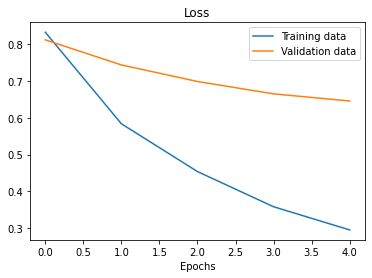

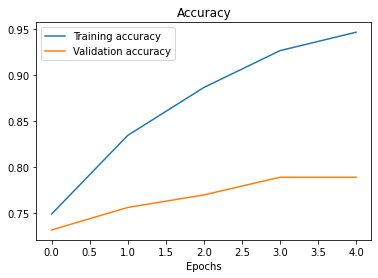

In [21]:
# Plotting our resnet model's losses
plot_loss_curves(history1)

In [28]:
# Creating EfficientNet model
model_efficientnet = create_model(url_efficientnet, num_classes=train_data_10_percent.num_classes)

In [29]:
# Checking the model
model_efficientnet.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [30]:
# Compiling the model
model_efficientnet.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [31]:
# Fit the model
history2 = model_efficientnet.fit(
    train_data_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data_10_percent,
    validation_steps=len(test_data_10_percent),
    callbacks=[create_tensorboard_callback("./", "effnet_1")]
)

Saving TensorBoard log files to .//effnet_1/20221204-154320
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9070 - accuracy: 0.4040

In [ ]:
# Plotting our efficientnet model's losses
plot_loss_curves(history2)